# Starter : Clustering of 3k PBMCs sequenced by 10X scRNA-seq

First, load dependencies. 

In [8]:
import sys
sys.path.append("./")
import pandas as pd
import numpy as np
from settings import settings, paths
import os
import muffin
import scanpy as sc

You can set plot settings for muffin :

In [9]:
muffin.params["autosave_plots"] = "3k_pbmc/"
muffin.params["figure_dpi"] = 96
muffin.params["autosave_format"] = ".pdf"
sc.set_figure_params(dpi=96, dpi_save=500)
sc.set_figure_params(dpi=96, dpi_save=500)
sc.settings.autosave = True
sc.settings.figdir = "3k_pbmc/"
# Makes pdf font editable with pdf editors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

We can load the dataset using scanpy functions, however muffin does not support sparse matrices :

In [10]:
dataset = sc.datasets.pbmc3k()
dataset.X = dataset.X.astype(np.int32).toarray()

The dataset is in an anndata object, which allows for an easy annotation of the count matrix, and the storage of different count transforms. Results will be stored in this object.

In [11]:
print(dataset)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


Here, we perform some standard QC (counts, percentage of mitochondrial RNA, number of detected genes...) on cells to remove low quality cells.

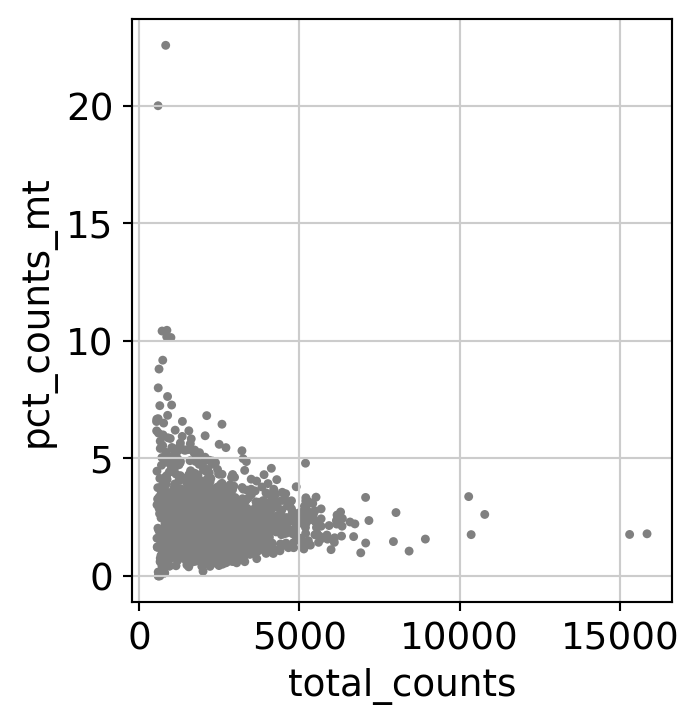

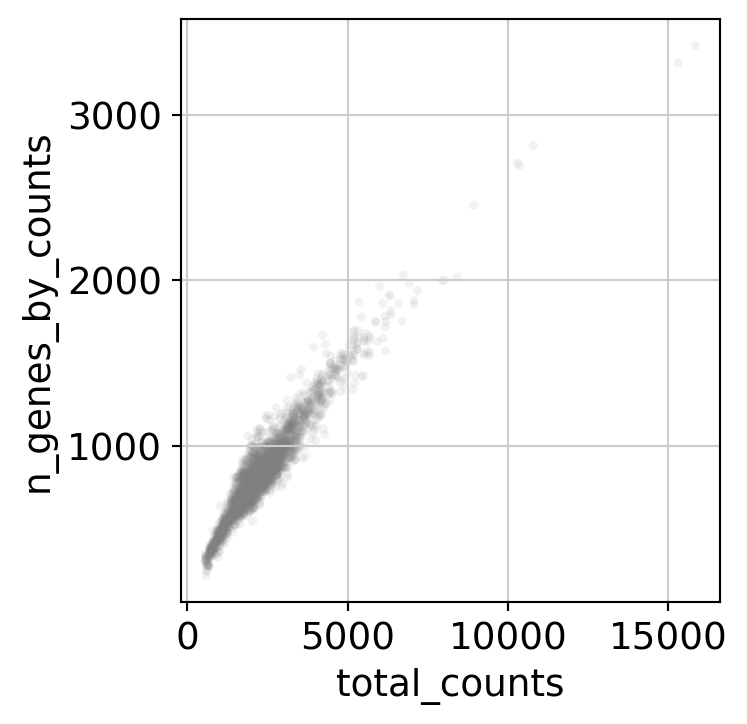

In [12]:
dataset.var['mt'] = dataset.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(dataset, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(dataset, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(dataset, x='total_counts', y='n_genes_by_counts', alpha=0.1)
# Same cutoffs as Seurat
dataset = dataset[dataset.obs.pct_counts_mt < 5, :]
dataset = dataset[dataset.obs.n_genes_by_counts < 2500, :]
dataset = dataset[dataset.obs.n_genes_by_counts > 200, :]

Here, we set up the design matrix of the linear model. If you do not want to regress any confounding factors leave it to a column array of ones as in the example. Note that it can have a tendency to "over-regress" and remove biological signal as it is a simple linear correction.

In [13]:
design = np.ones((dataset.X.shape[0],1))
muffin.load.set_design_matrix(dataset, design)

Now, we are going to normalize library sizes using the scran approach, which is well suited to a large number of observations and small counts with many zeroes. We are also going to remove features with very low signal (note that this is mandatory to remove all zero counts).

In [14]:
detectable = muffin.tools.trim_low_counts(dataset)
dataset = dataset[:, detectable]
muffin.tools.compute_size_factors(dataset, "scran")

AnnData object with n_obs × n_vars = 2638 × 13656
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'size_factors'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'design'

The next step is to fit the mean-variance relationship and compute residuals to the fitted Negative Binomial model.

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 832 tasks      | elapsed:   10.5s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:   13.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 12464 tasks      | elapsed:   16.3s
[Parallel(n_jobs=8)]: Done 13656 out of 13656 | elapsed:   17.4s finished


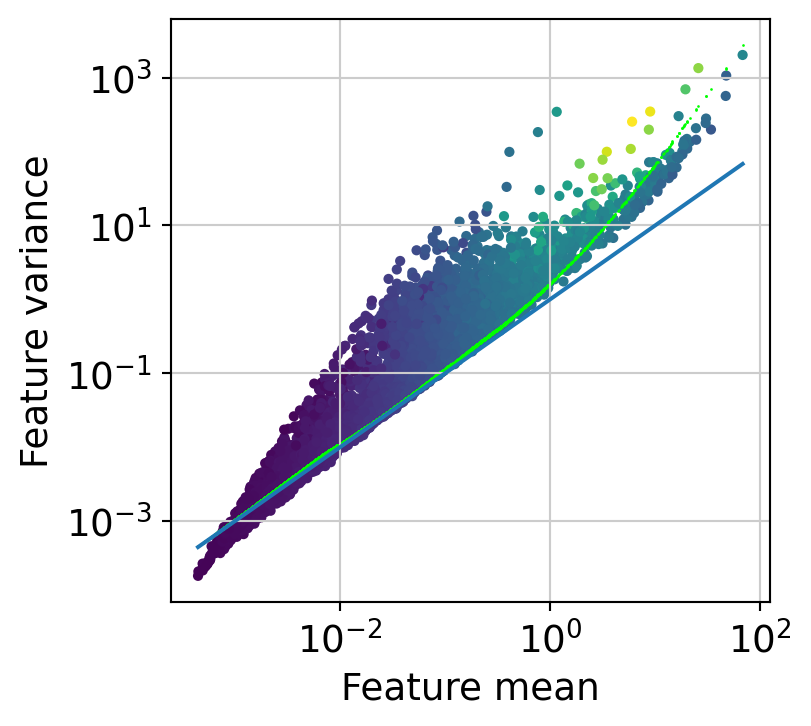

AnnData object with n_obs × n_vars = 2638 × 13656
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'size_factors'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'reg_alpha'
    obsm: 'design'
    layers: 'residuals'

In [15]:
muffin.tools.compute_residuals(dataset, maxThreads=8)

Next, we perform dimensionnality reduction with PCA (automatically finding the optimal dimensionnality) and UMAP.

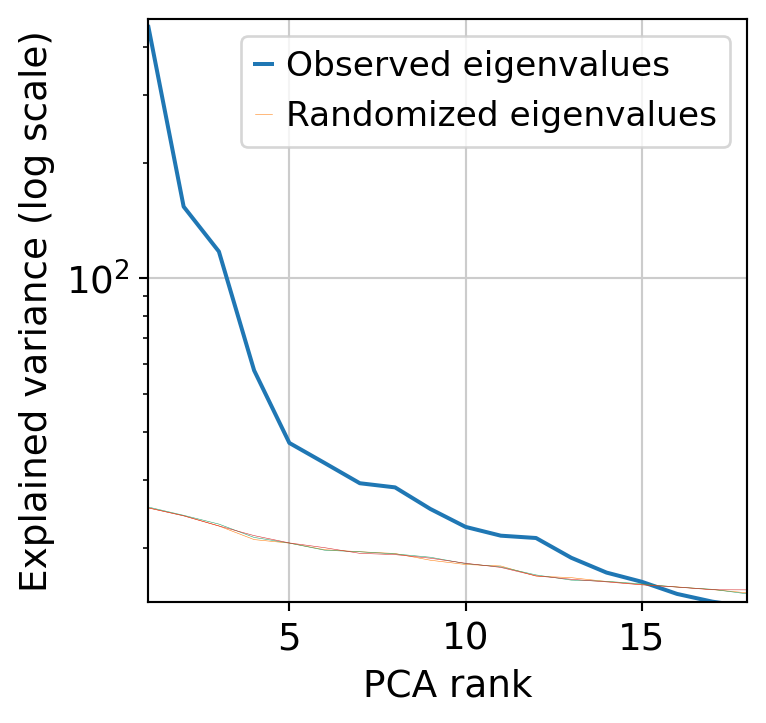

AnnData object with n_obs × n_vars = 2638 × 13656
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'size_factors'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'reg_alpha'
    uns: 'pca'
    obsm: 'design', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'residuals'

In [16]:
muffin.tools.compute_pa_pca(dataset, max_rank=50, plot=True)
muffin.tools.compute_umap(dataset)

Now, cluster the cells.

In [27]:
muffin.tools.cluster_rows_leiden(dataset)

AnnData object with n_obs × n_vars = 2638 × 13656
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'size_factors', 'leiden', 'Annotated clusters'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'reg_alpha'
    uns: 'pca', 'leiden_colors', 'rank_genes_groups', 'Annotated clusters_colors', 'dendrogram_Annotated clusters'
    obsm: 'design', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'residuals', 'scaled'

Display the results. Note that we can use scanpy functions here!

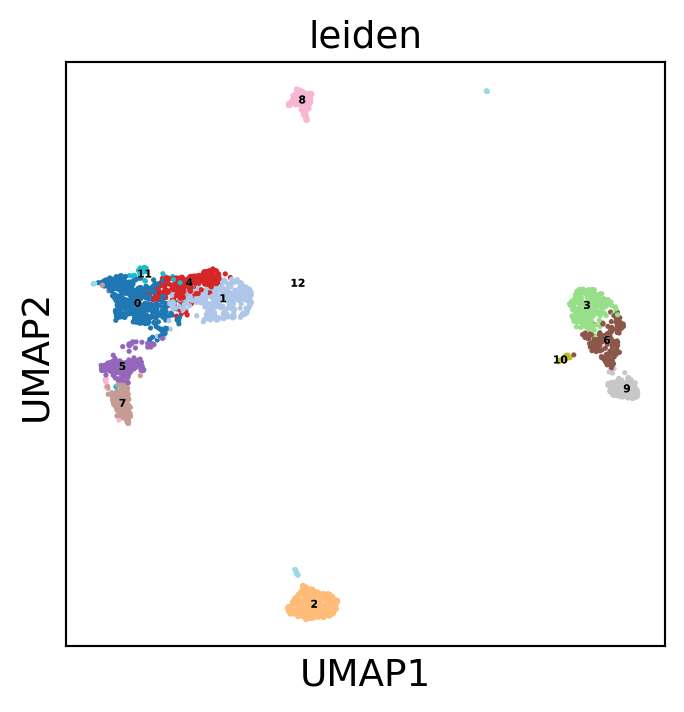

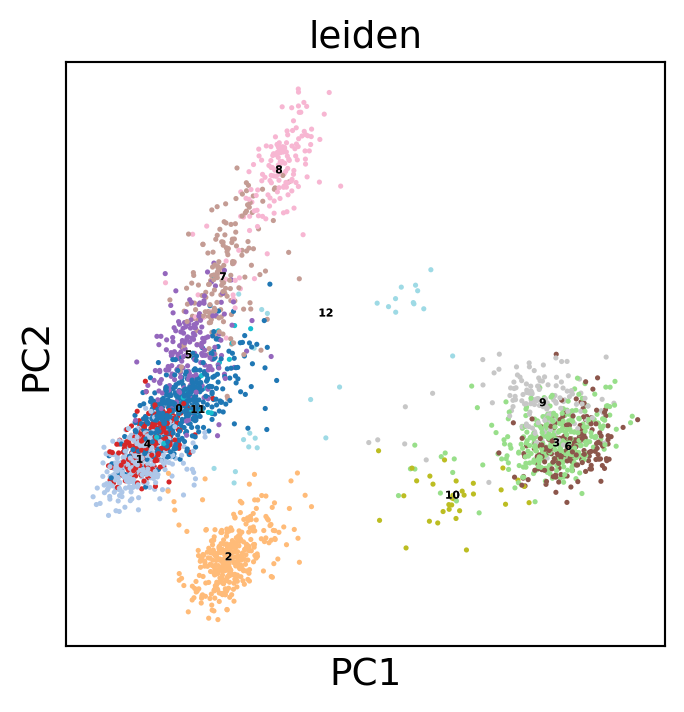

In [18]:
# Append cell type info to the dataset
sc.pl.umap(dataset, color='leiden', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='tab20')
sc.pl.pca(dataset, color='leiden', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='tab20')

Let's find markers using a logistic regression :

In [19]:
from sklearn.preprocessing import StandardScaler
# It is strongly advised to standardize inputs for a better convergence of the solver (especially for large datasets).
dataset.layers["scaled"] = StandardScaler().fit_transform(dataset.layers["residuals"])
sc.tl.rank_genes_groups(dataset, 'leiden', use_raw=False, layer="scaled",
                        method='logreg', class_weight="balanced")

We can see some known markers of well-known cell types (LTB for cluster 0 - CD8 T Cells, PPBP for cluster 12 - platelets):

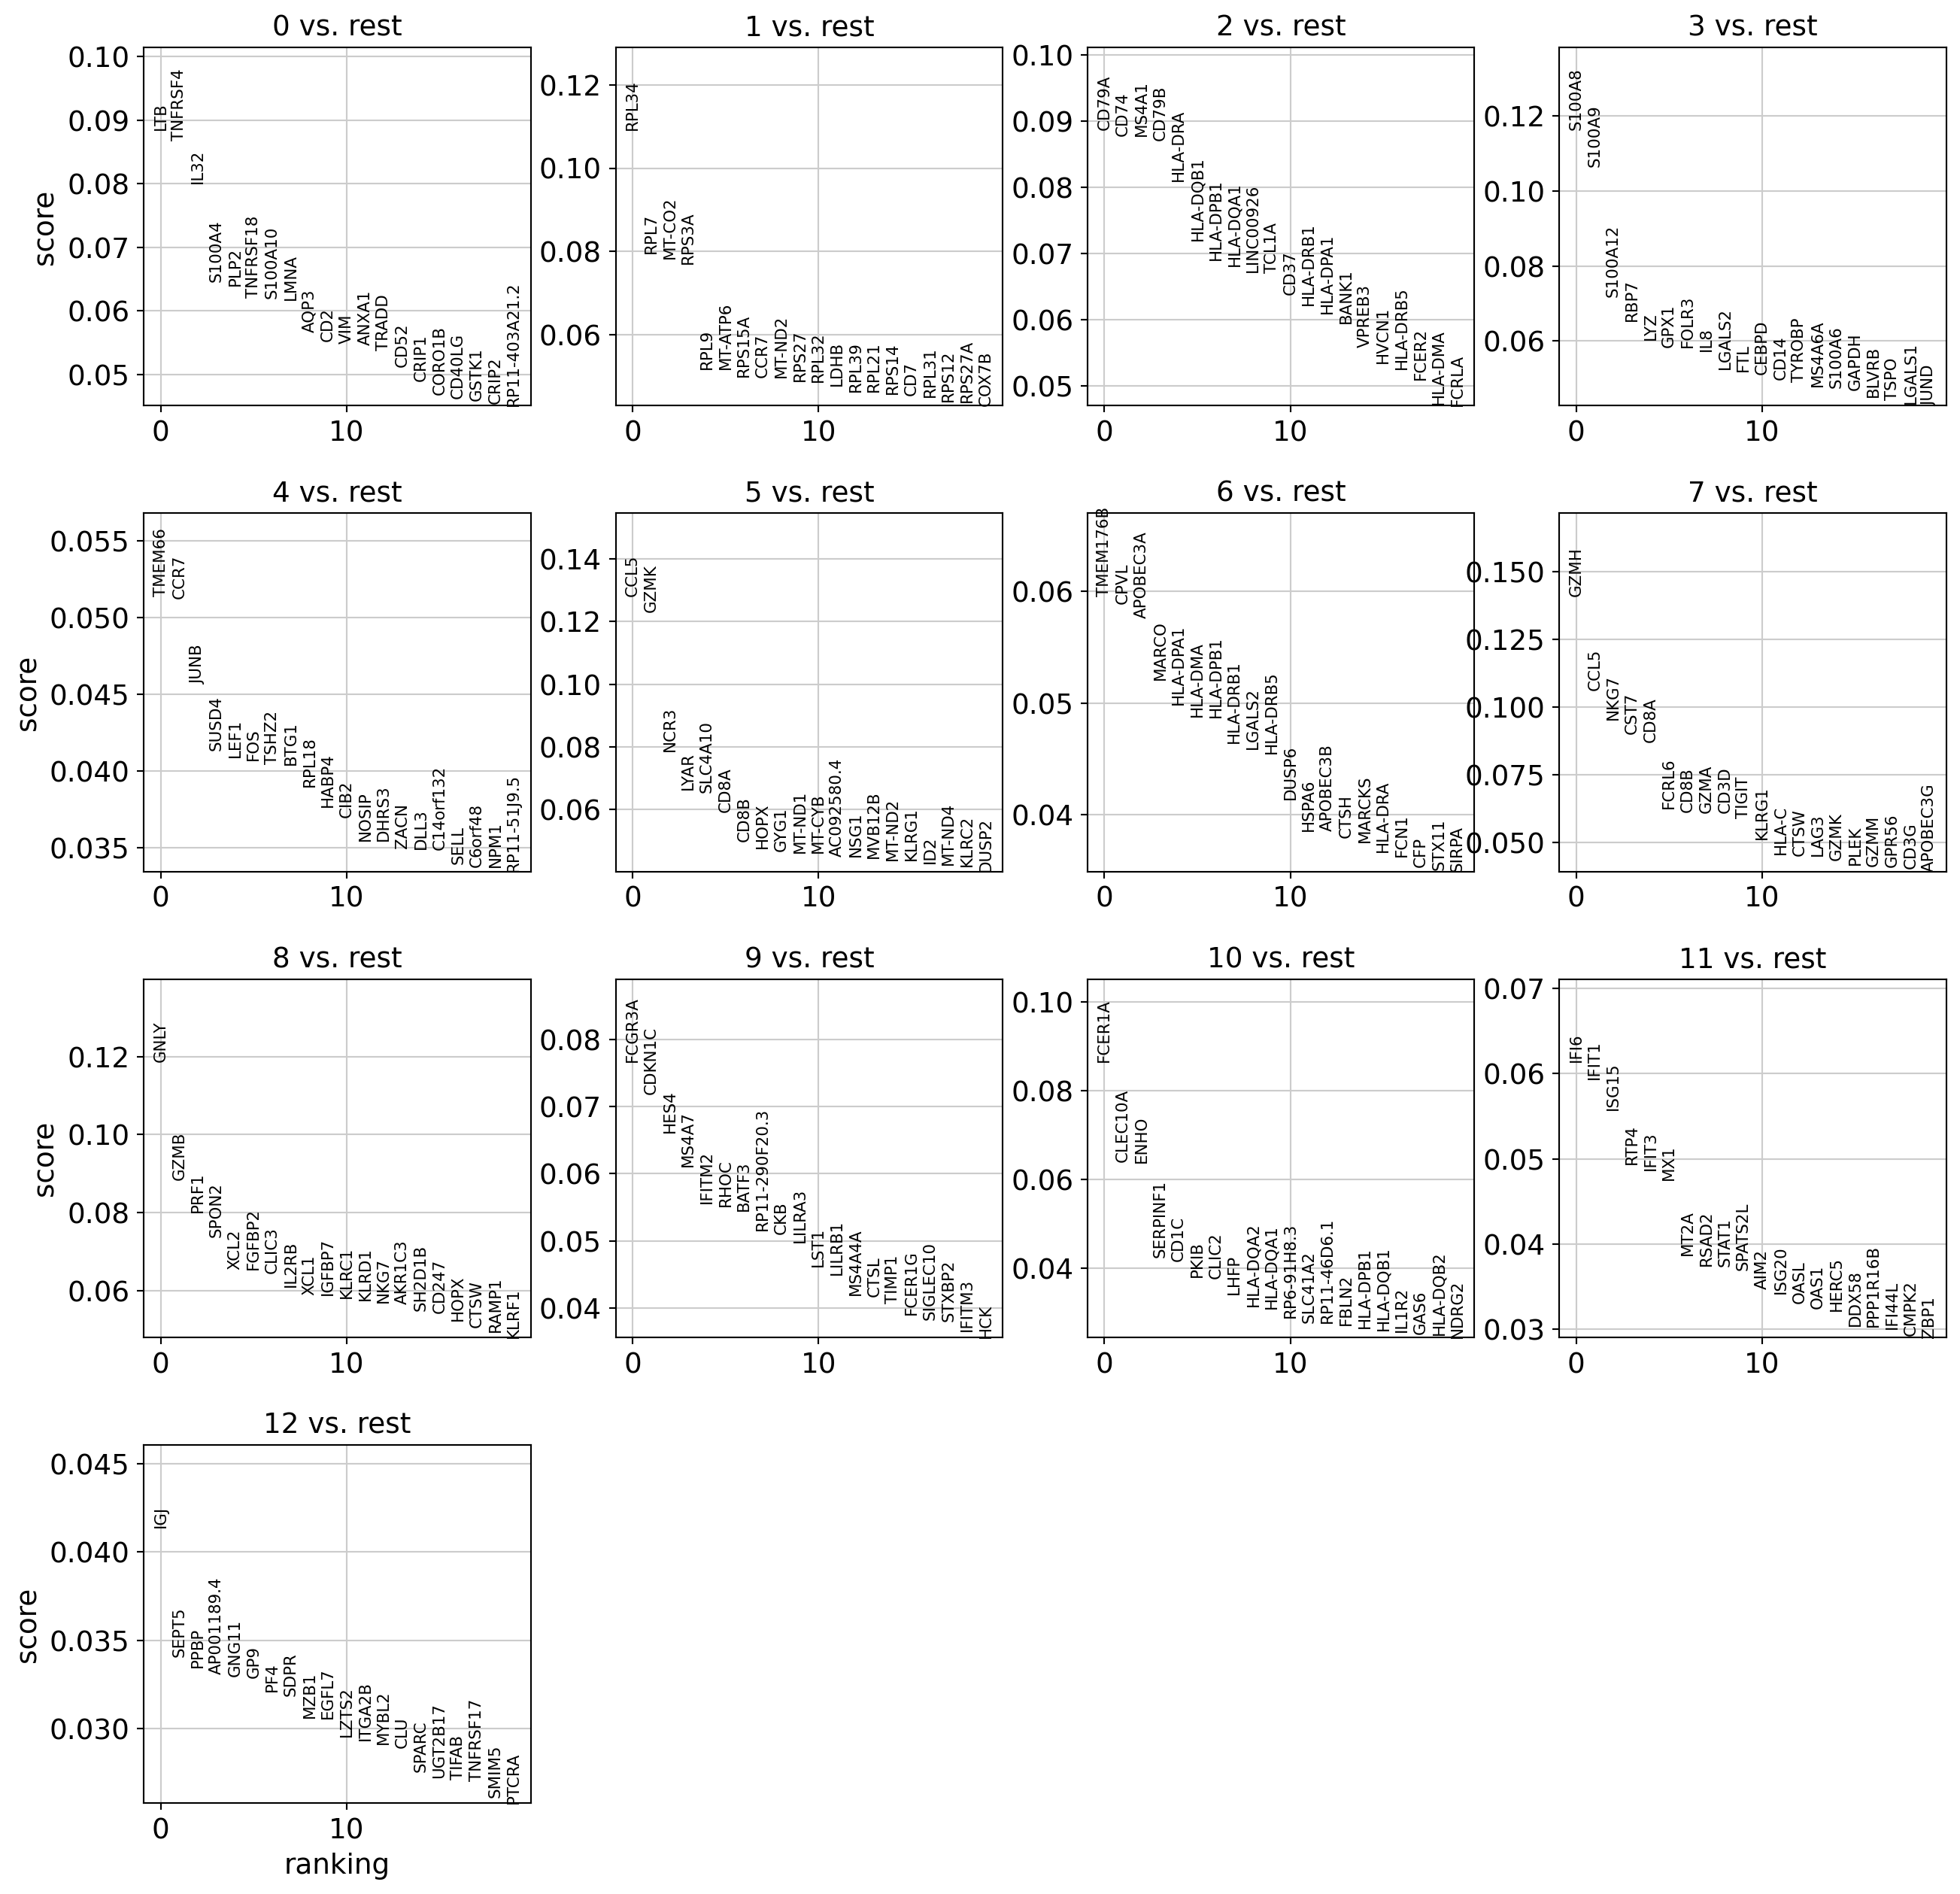

In [20]:
sc.pl.rank_genes_groups(dataset, sharey=False)

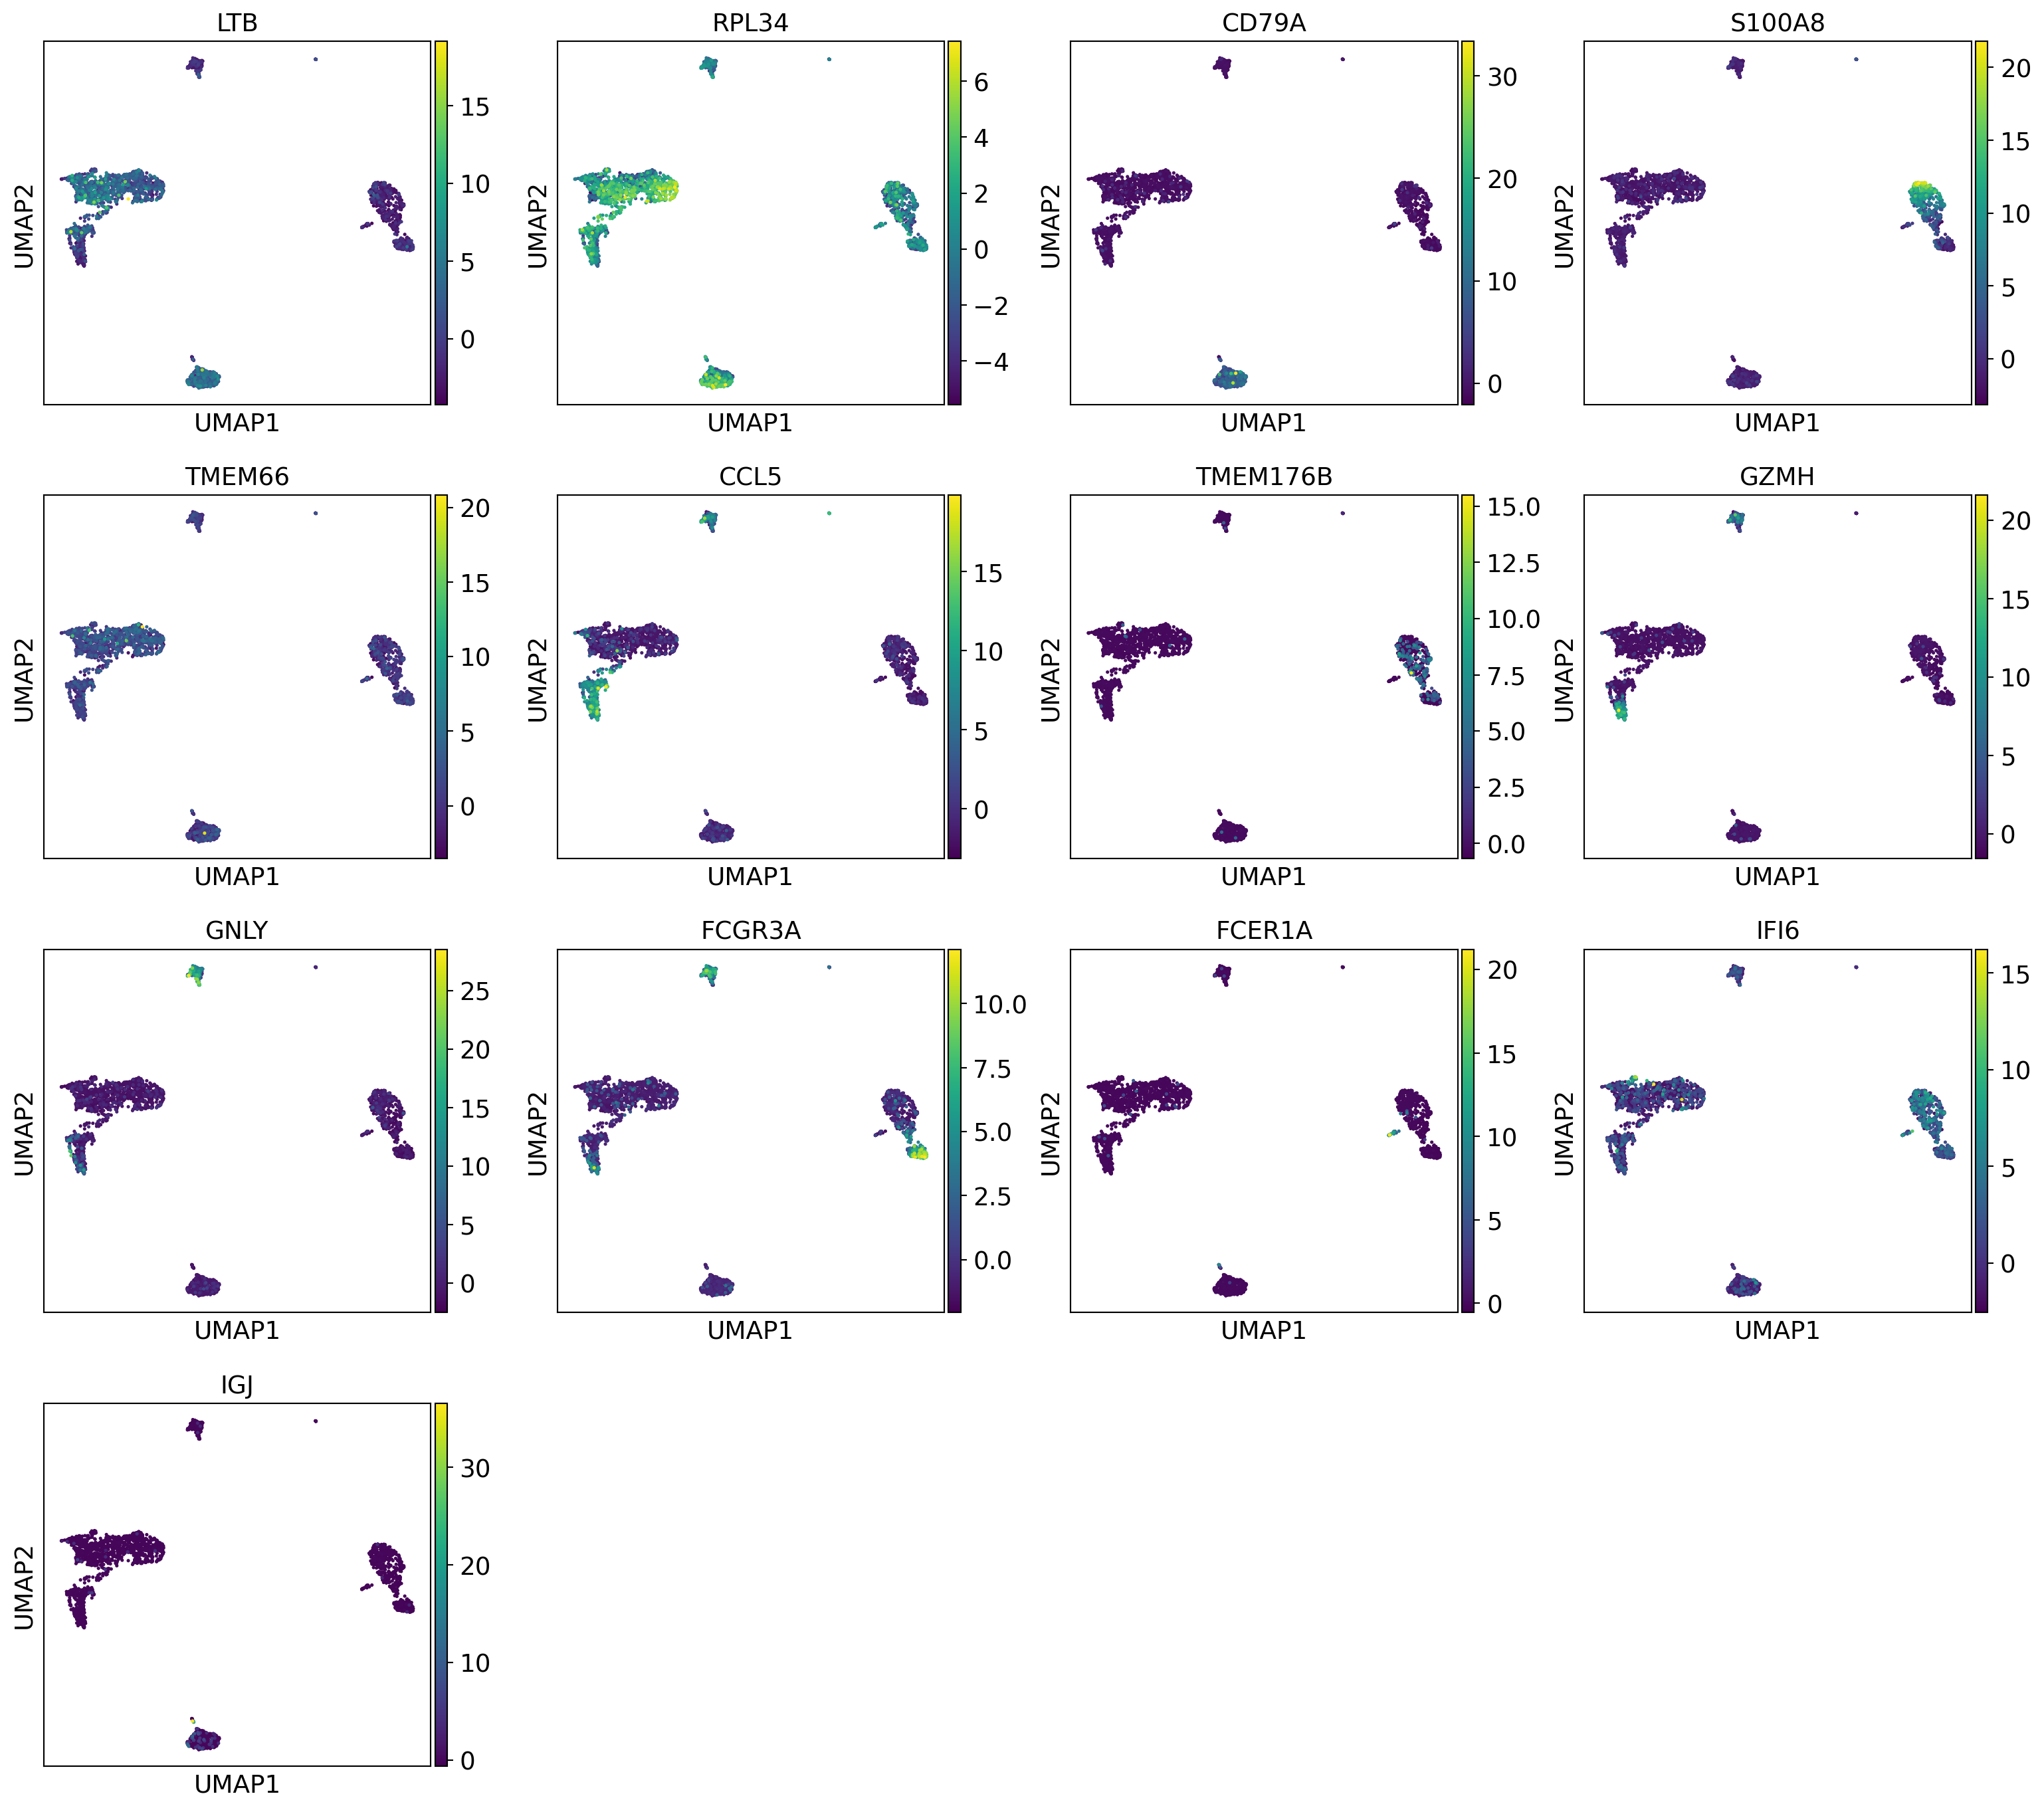

In [21]:
bestmarkers = [dataset.uns["rank_genes_groups"]["names"][0][i] for i in range(len(dataset.uns["rank_genes_groups"]["names"][0]))]
sc.pl.umap(dataset, color=bestmarkers, 
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='tab20', layer="residuals", save=f"umap_monocyte_markers.pdf")

Let's annotate cell types :

In [28]:
cluster_names = {"0":"T-Cells CD4 Memory",
                 "1":"T-Cells CD4+ Naive RPL34+",
                 "2":"B-Cells",
                 "3":"Monocytes S100A8+",
                 "4":"T-Cells CD4+ Naive",
                 "5":"T-Cells CD8+",
                 "6":"Monocytes APOBEC3A+",
                 "7":"T-Cells CD8 GZMH+",
                 "8":"NK Cells",
                 "9":"Monocytes FCGR3A+",
                 "10":"Dendritic Cell",
                 "11":"T-Cells IFN stimulated",
                 "12":"Platelets"
                 }
dataset.obs["Annotated clusters"] = pd.Series(cluster_names)[dataset.obs["leiden"]].values

We can re-plot with annotated clusters

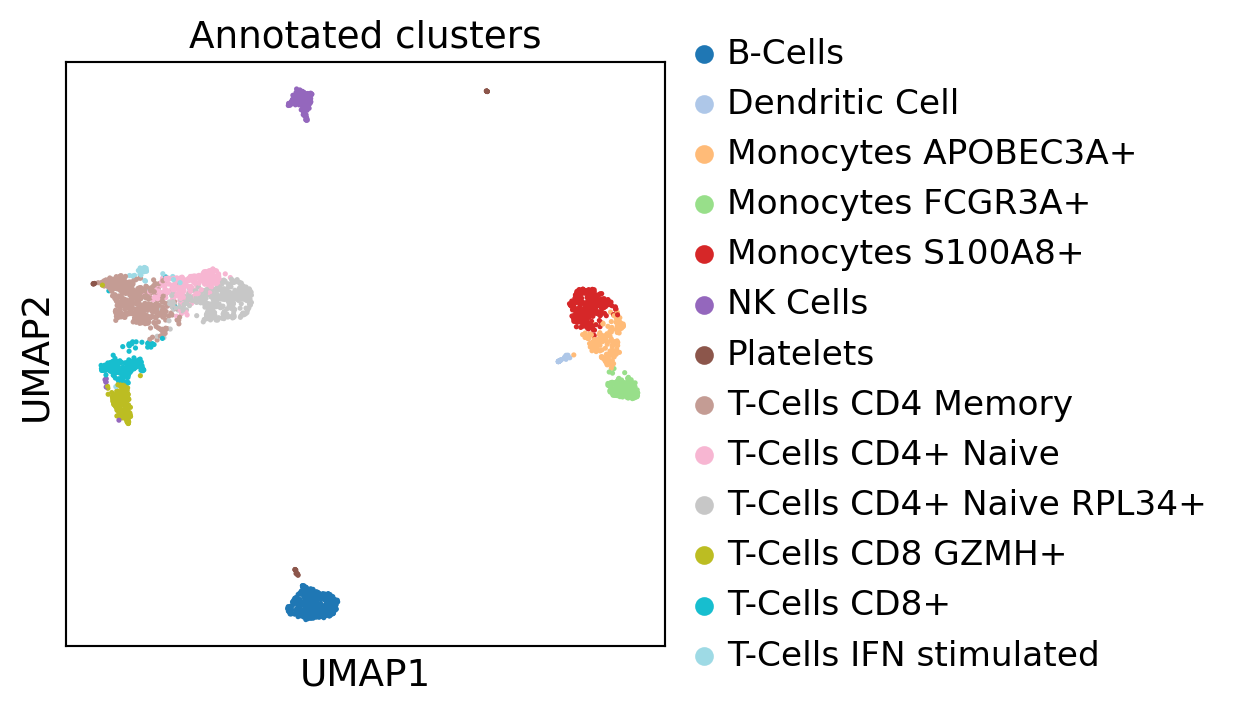

In [29]:
sc.pl.umap(dataset, color="Annotated clusters",  s=15.0,
                palette='tab20', layer="residuals", vmax=5, save=f"umap_annot.pdf")

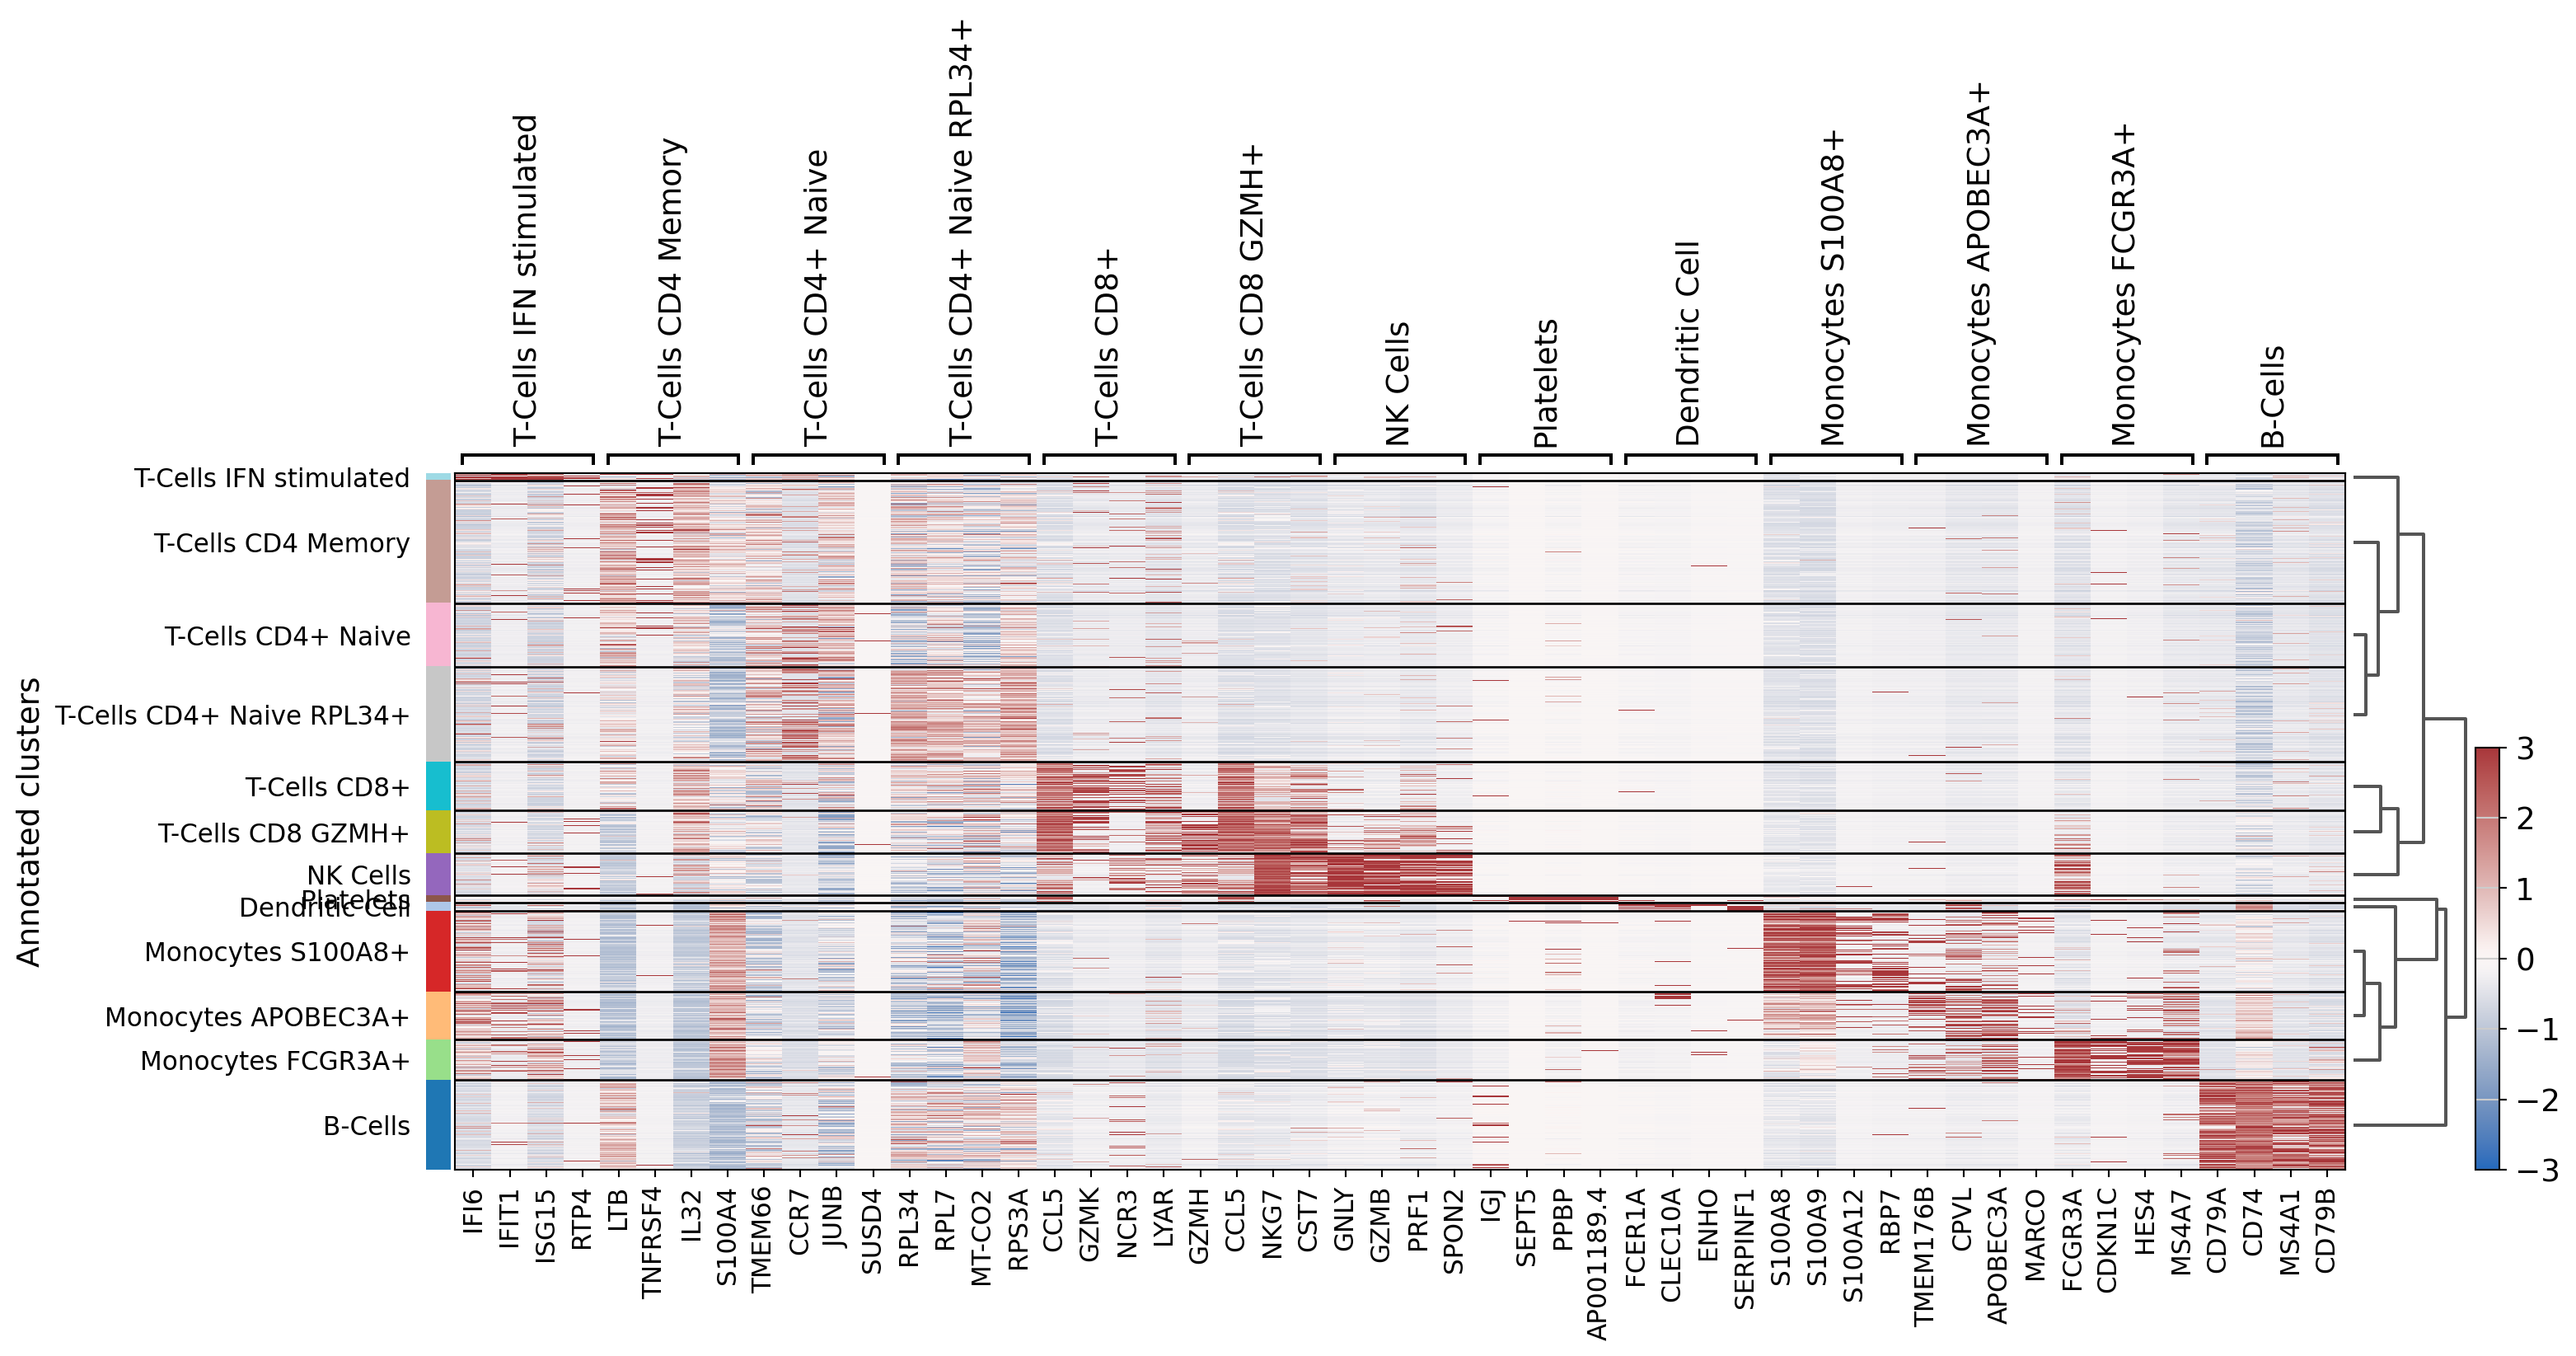

In [30]:
# Ugly hack to solve an issue with scanpy logreg that does not output all fields
dataset.uns["rank_genes_groups"]["logfoldchanges"] = dataset.uns["rank_genes_groups"]["scores"]
dataset.uns["rank_genes_groups"]["pvals"] = dataset.uns["rank_genes_groups"]["scores"]
dataset.uns["rank_genes_groups"]["pvals_adj"] = dataset.uns["rank_genes_groups"]["scores"]
dataset.obs["leiden"] = dataset.obs["Annotated clusters"]
sc.tl.dendrogram(dataset, groupby="Annotated clusters", optimal_ordering=True, linkage_method="average")
sc.tl.rank_genes_groups(dataset, 'Annotated clusters', use_raw=False, layer="scaled",
                        method='logreg', class_weight="balanced")
sc.pl.rank_genes_groups_heatmap(dataset, layer="scaled", use_raw=False, 
                                vmin=-3, vmax=3, cmap="vlag", show_gene_labels=True,
                                n_genes=4)

We can save our work to avoid recomputing everything. It can easily be re-loaded using :  anndata.read_h5ad(path). We can also see that our dataset carries much more data than at the start.

In [31]:
dataset.write("3k_pbmc/dataset.h5ad")
print(dataset)

AnnData object with n_obs × n_vars = 2638 × 13656
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'size_factors', 'leiden', 'Annotated clusters'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'reg_alpha'
    uns: 'pca', 'leiden_colors', 'rank_genes_groups', 'Annotated clusters_colors', 'dendrogram_Annotated clusters'
    obsm: 'design', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'residuals', 'scaled'
